### Preliminaries

In [ ]:
# install deepxde

%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
# import packages

import deepxde as dde
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



In [ ]:
torch.cuda.is_available()

device = torch.device("cuda")

### DeepXDE Setup

In [ ]:
# define the PDE

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

In [ ]:
# define a computational geometry and a time domain

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
# define the boundary and initial conditions

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [ ]:
# define the time PDE problem

data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=25400, num_boundary=80, num_initial=160)

In [ ]:
# choose the network architecture and the training method

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.MsFFN(layer_size, activation, initializer, sigmas=[1.0])

model = dde.Model(data, net)

model.compile("adam", lr=1e-5, loss_weights=[1, 1, 1])

Compiling model...
Building Multiscale Fourier Feature Network...


/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.642463 s



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/229 Project'

# import data for the true solution
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

Mounted at /content/drive
/content/drive/My Drive/229 Project


### Train Model & Save Predictions

In [ ]:
import pickle

# train the model
model_preds = {}

for iter in range(600):
  losshistory, train_state = model.train(iterations=500)
  X, y_true = gen_testdata()
  y_pred = model.predict(X)
  cur_iter = (iter + 1) * 500
  model_preds[cur_iter] = y_pred

with open('burgers_ffn_sigma1_preds.pkl', 'wb') as f:
  pickle.dump(model_preds, f)

Streaming output truncated to the last 5000 lines.

Best model at step 108000:
  train loss: 2.01e-04
  test loss: 2.01e-04
  test metric: []

'train' took 3.619170 s

Training model...

Step      Train loss                        Test loss                         Test metric
108000    [1.02e-04, 4.69e-07, 9.85e-05]    [1.02e-04, 4.69e-07, 9.85e-05]    []  
108500    [1.01e-04, 4.59e-07, 9.75e-05]    [1.01e-04, 4.59e-07, 9.75e-05]    []  

Best model at step 108500:
  train loss: 1.99e-04
  test loss: 1.99e-04
  test metric: []

'train' took 3.628911 s

Training model...

Step      Train loss                        Test loss                         Test metric
108500    [1.01e-04, 4.59e-07, 9.75e-05]    [1.01e-04, 4.59e-07, 9.75e-05]    []  
109000    [1.01e-04, 4.59e-07, 9.65e-05]    [1.01e-04, 4.59e-07, 9.65e-05]    []  

Best model at step 109000:
  train loss: 1.98e-04
  test loss: 1.98e-04
  test metric: []

'train' took 4.183626 s

Training model...

Step      Train loss         

### Fourier Analysis

#### Helper Functions

In [ ]:
def get_fft(y, sampling_rate):
  # Calculate the Fourier transform of f(x)
  fourier = np.fft.fft(y.squeeze())

  length = len(y)

  # Calculate the corresponding frequencies
  freq = np.fft.fftfreq(length, 1/sampling_rate)

  results = list(zip(freq, np.abs(fourier)))
  filtered = [(x, y) for (x, y) in results if x > 0]
  results = list(zip(*filtered))

  return results

In [ ]:
def compare_solutions(t, y_true, y_pred):
  start = int(256 * t * 100)
  end = start + 256

  fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))

  ax0.plot(X[:, 0][start:end], y_true[start:end], "b-", label="Exact")
  ax0.plot(X[:, 0][start:end], y_pred[start:end], "r--", label="Prediction")
  ax0.legend()
  ax0.set_title(f"Comparing Solutions at Time {t}")
  ax0.set_xlabel("x")
  ax0.set_ylabel("u(x, t)")

  true_freq, true_fourier = get_fft(y_true[start:end], 256/2)
  pred_freq, pred_fourier = get_fft(y_pred[start:end], 256/2)
  ax1.plot(true_freq, true_fourier, "b-", label="Exact")
  ax1.plot(pred_freq, pred_fourier, "r--", label="Prediction")
  ax1.legend()
  ax1.set_title(f"Comparing Fourier Transforms of Solutions at Time {t}")
  ax1.set_xlabel("Frequency")
  ax1.set_ylabel("Amplitude")

  fourier_diff = abs(np.array(true_fourier) - np.array(pred_fourier))
  ax2.plot(true_freq, fourier_diff, "b-")
  ax2.set_title(f"Difference in Fourier Transforms of Solutions at Time {t}")
  ax2.set_xlabel("Frequency")
  ax2.set_ylabel("Absolute Difference in Amplitude")
  
  plt.show()

In [ ]:
import pandas as pd
from matplotlib.colors import LogNorm, Normalize

def plot_spectral_dynamics(all_preds, y_true, t):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

    start = int(256 * t * 100)
    end = start + 256
    true_freq, true_fourier = get_fft(y_true[start:end], 256/2)

    pct_dict = {"iter": [], "freq": [], "value": []}
    error_dict = {"iter": [], "freq": [], "value": []}
    # Compute spectra for all frames
    for iter, pred in all_preds.items(): 
        if iter % 1000 == 0 or iter == 500:
          pred_freq, pred_fourier = get_fft(pred[start:end], 256/2)
          pct_diff = abs(np.array(pred_fourier) - np.array(true_fourier))/np.array(true_fourier) * 100
          abs_diff = abs(np.array(pred_fourier) - np.array(true_fourier))

          for idx, freq in enumerate(pred_freq):
            pct_dict["iter"].append(iter)
            pct_dict['freq'].append(freq)
            pct_dict['value'].append(pct_diff[idx])

            error_dict["iter"].append(iter)
            error_dict['freq'].append(freq)
            error_dict['value'].append(abs_diff[idx])


    pct_diffs = pd.DataFrame(data = pct_dict)
    pct_diffs = pct_diffs.round(3)
    pct_diffs = pct_diffs.pivot("iter", "freq", "value")
    sns.heatmap(pct_diffs, yticklabels=3, xticklabels=10, vmin=0., vmax=100, cbar_kws={'label': 'Percentage Error in Amplitude'}, ax=ax0, cmap="BuPu")
    ax0.invert_yaxis()
    ax0.set_xlabel("Frequency")
    ax0.set_ylabel("Training Iteration")
    ax0.set_title(f"Frequency Dynamics of Predicted Solution at t = {t}")


    abs_diffs = pd.DataFrame(data = error_dict)
    abs_diffs = abs_diffs.round(3)
    abs_diffs = abs_diffs.pivot("iter", "freq", "value")
    sns.heatmap(abs_diffs, yticklabels=3, xticklabels=10, vmin=0., vmax=max(error_dict['value']), cbar_kws={'label': 'Absolute Error in Amplitude'}, ax=ax1, cmap="BuPu")
    ax1.invert_yaxis()
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Training Iteration")
    ax1.set_title(f"Frequency Dynamics of Predicted Solution at t = {t}")

    plt.show()

In [ ]:
def plot_l2_errors(preds, y_true, iteration):

    error_dict = {"time": [], "freq": [], "value": []}

    for t in np.linspace(0, 0.99, 100):
      start = int(256 * t * 100)
      end = start + 256
      true_freq, true_fourier = get_fft(y_true[start:end], 256/2)
      pred_freq, pred_fourier = get_fft(preds[start:end], 256/2)
      abs_diff = abs(np.array(pred_fourier) - np.array(true_fourier))

      for idx, freq in enumerate(pred_freq):
        error_dict["time"].append(t)
        error_dict['freq'].append(freq)
        error_dict['value'].append((abs_diff[idx] ** 2))


    l2_errors = pd.DataFrame(data = error_dict)
    l2_errors = l2_errors.round(3)
    l2_errors = l2_errors.pivot("time", "freq", "value")
    sns.heatmap(l2_errors, yticklabels=3, xticklabels=10, vmin=0, norm=LogNorm(), cbar_kws={'label': 'L2 Error of Prediction'}, cmap="BuPu")
    plt.gca().invert_yaxis()
    plt.xlabel("Frequency")
    plt.ylabel("Time")
    plt.title(f"Decomposing L2 Error of Predicted Solution at Iteration {iteration}")

    plt.show()

#### Load Predictions

In [ ]:
# compare the true solution with the predicted solution
X, y_true = gen_testdata()


with open('burgers_ffn_preds.pkl', 'rb') as f:
    all_preds = pickle.load(f)

# with open('burgers_ffn_sigma1_preds.pkl', 'rb') as f:
#     all_preds = pickle.load(f)

#### Visualizations

<ipython-input-12-6b261f63a22d>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-12-6b261f63a22d>:44: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


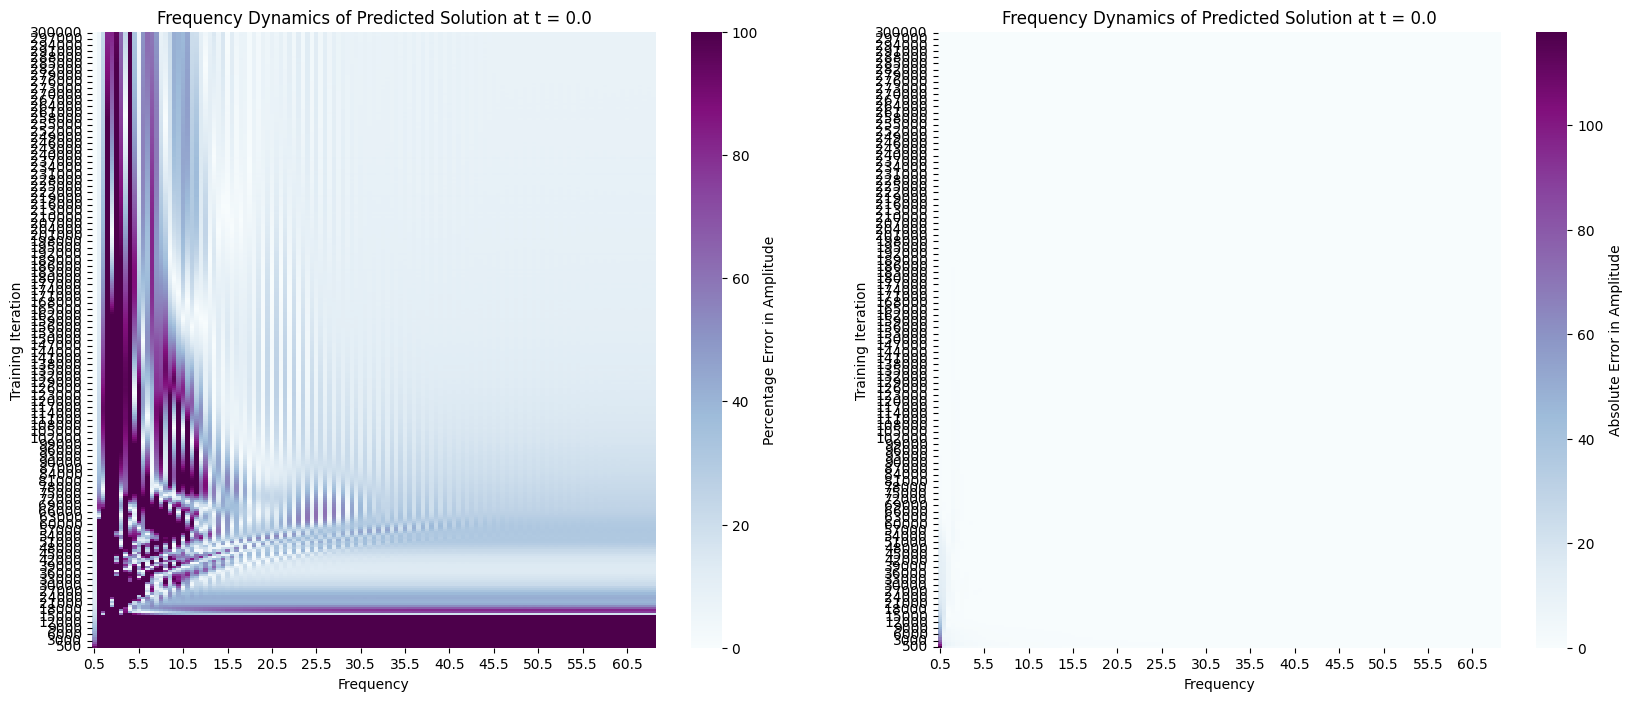

<ipython-input-12-6b261f63a22d>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-12-6b261f63a22d>:44: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


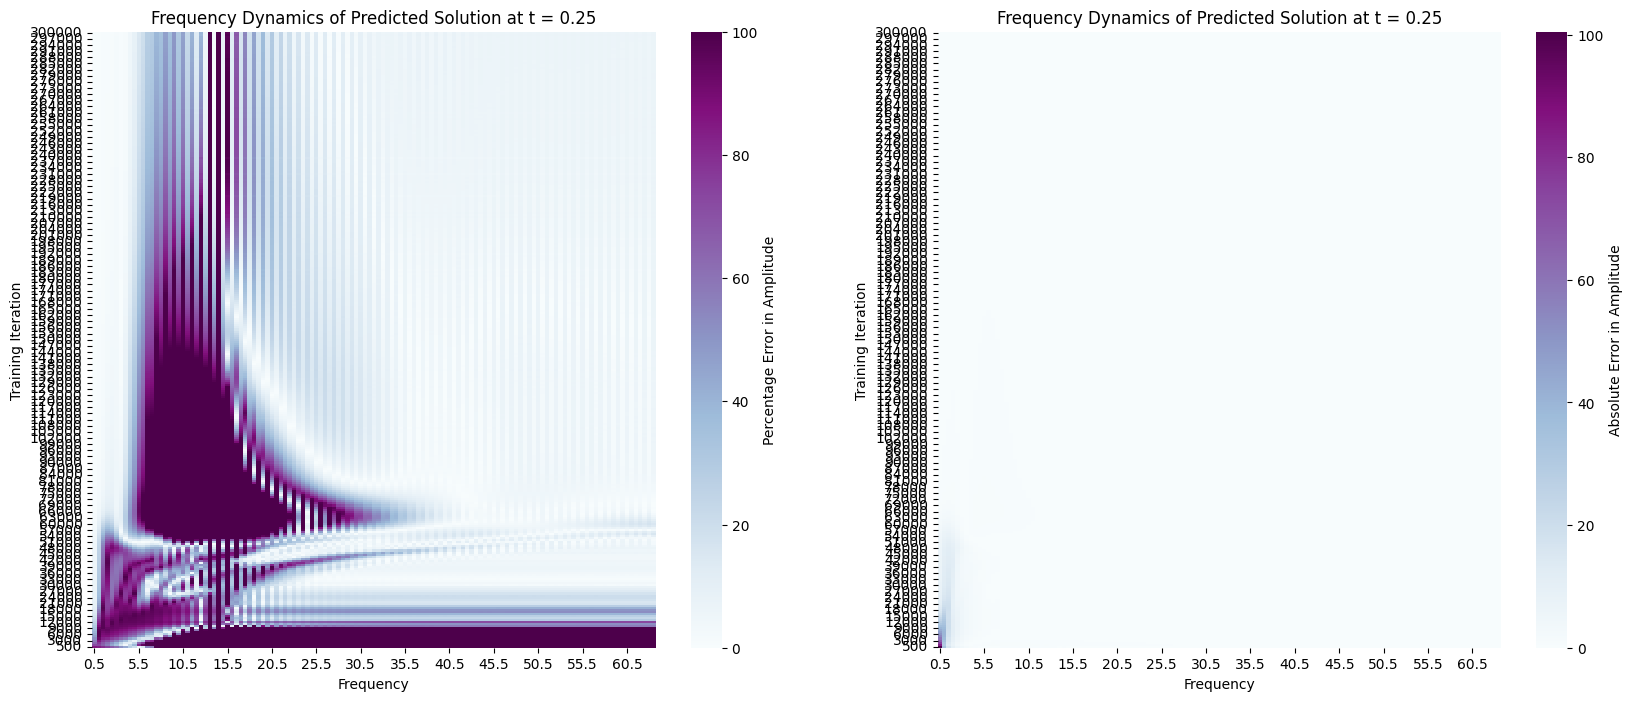

<ipython-input-12-6b261f63a22d>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-12-6b261f63a22d>:44: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


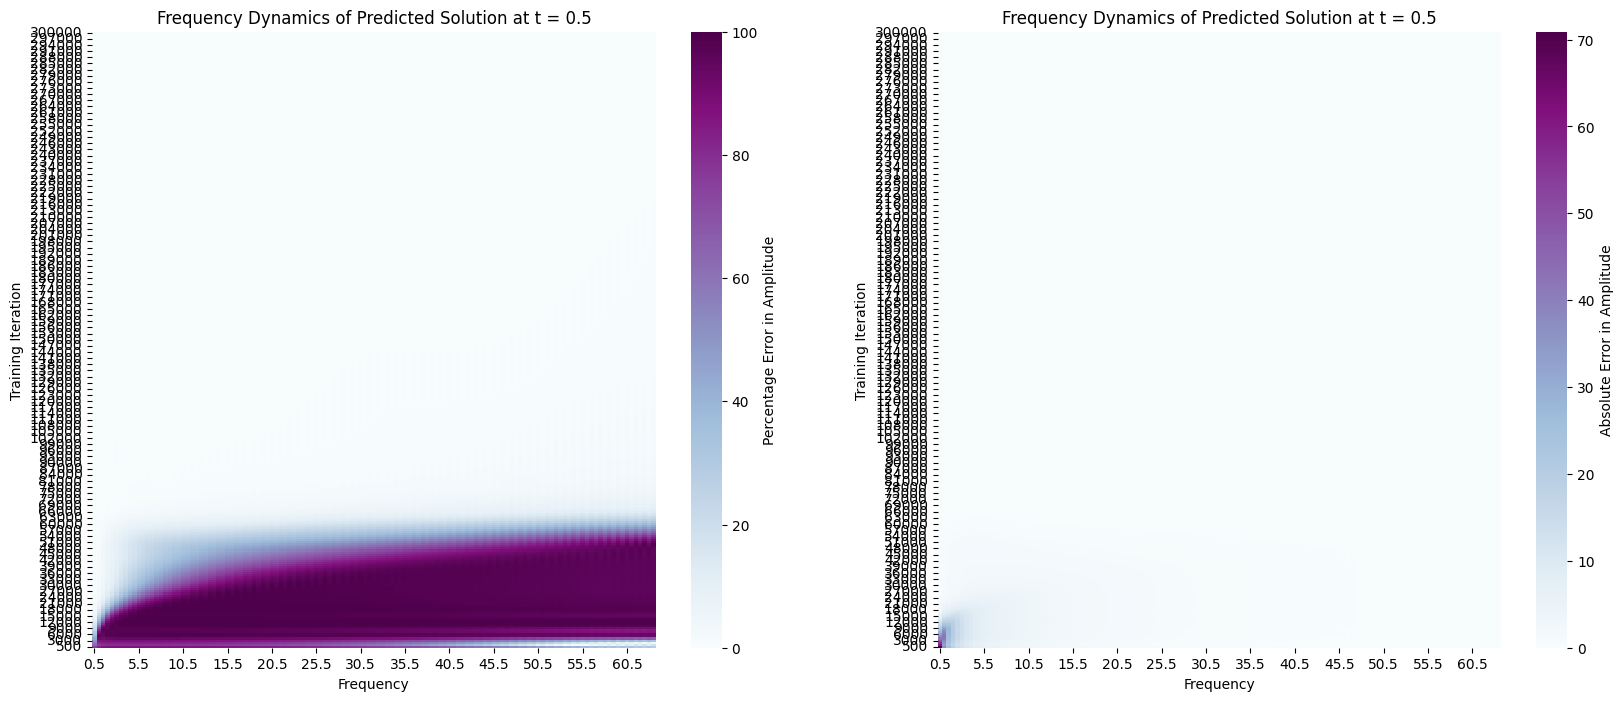

<ipython-input-12-6b261f63a22d>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-12-6b261f63a22d>:44: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


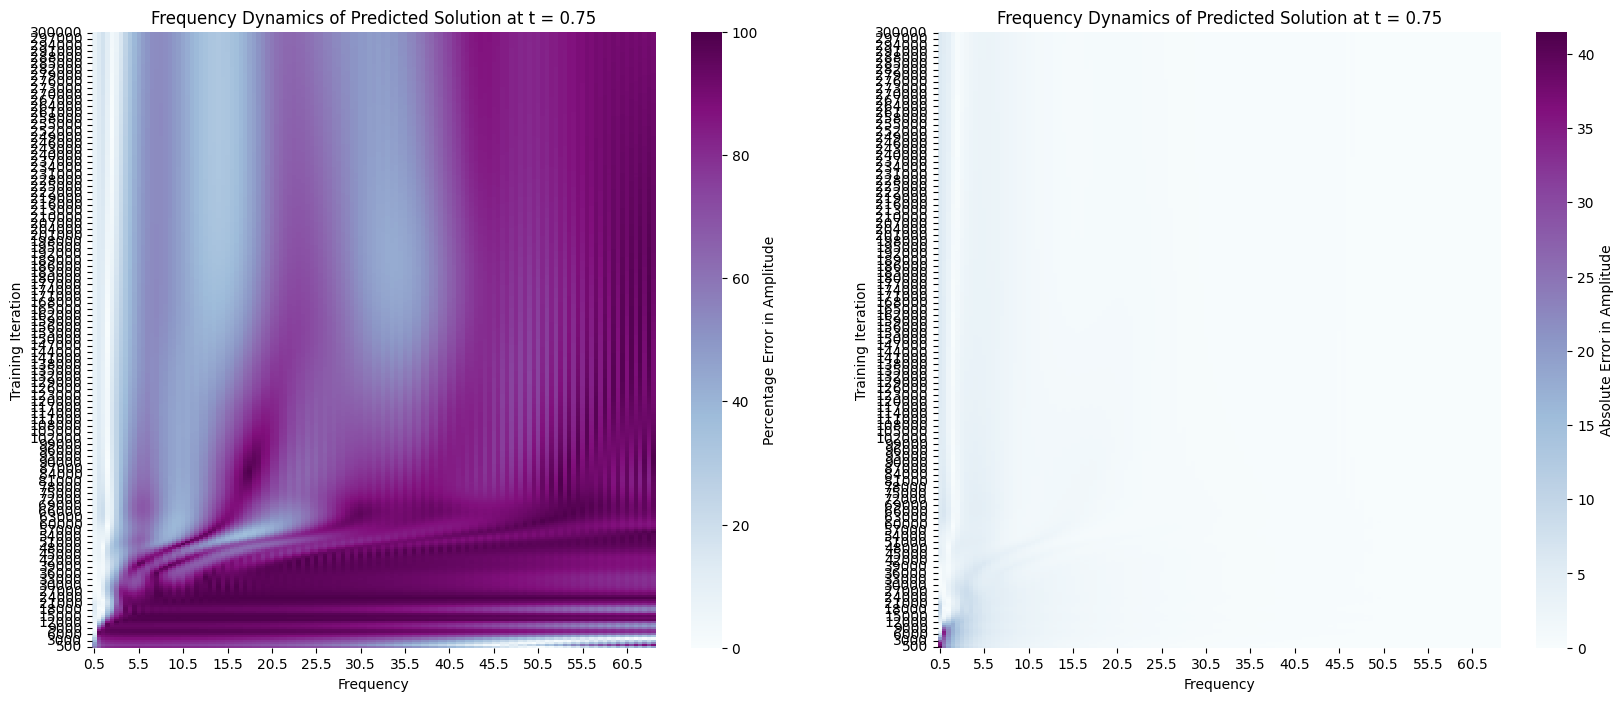

<ipython-input-12-6b261f63a22d>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-12-6b261f63a22d>:44: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


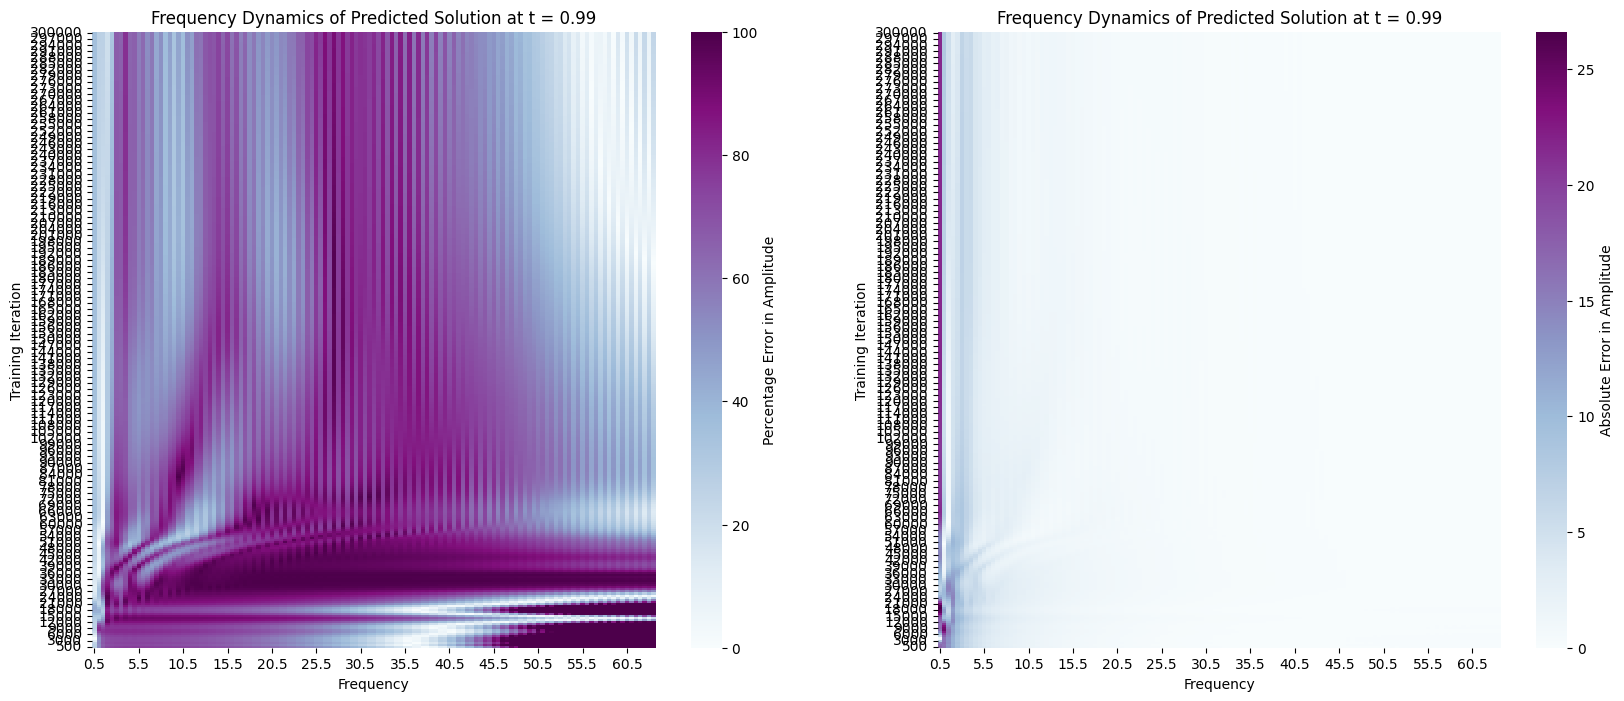

In [ ]:
plot_spectral_dynamics(all_preds, y_true, 0.00)
plot_spectral_dynamics(all_preds, y_true, 0.25)
plot_spectral_dynamics(all_preds, y_true, 0.50)
plot_spectral_dynamics(all_preds, y_true, 0.75)
plot_spectral_dynamics(all_preds, y_true, 0.99)

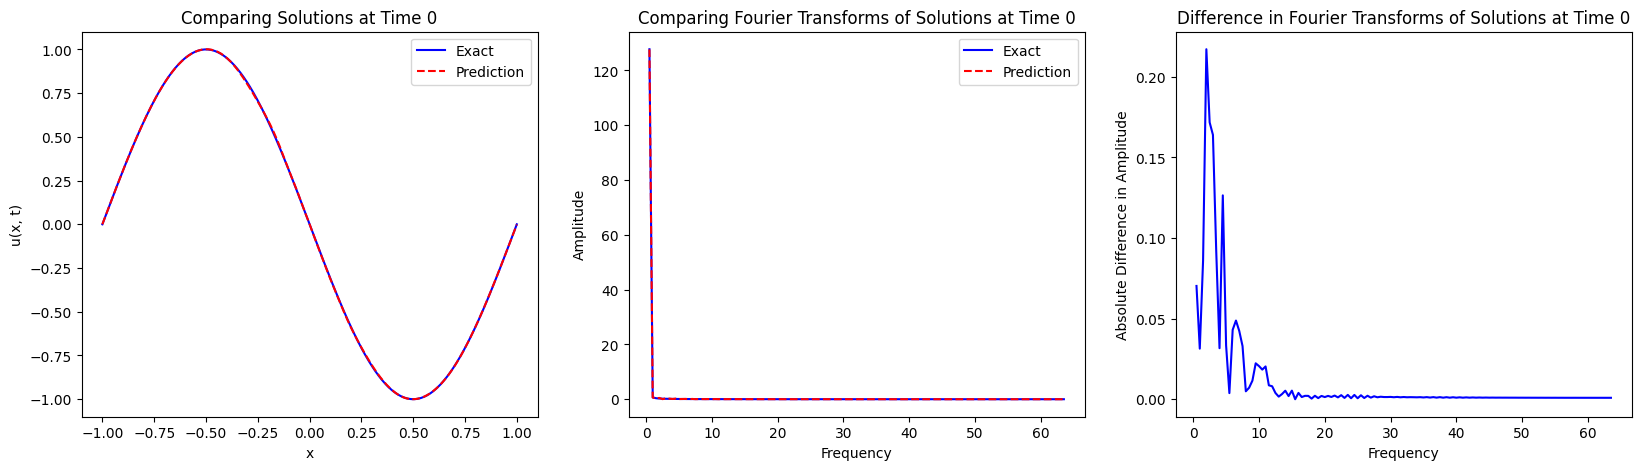

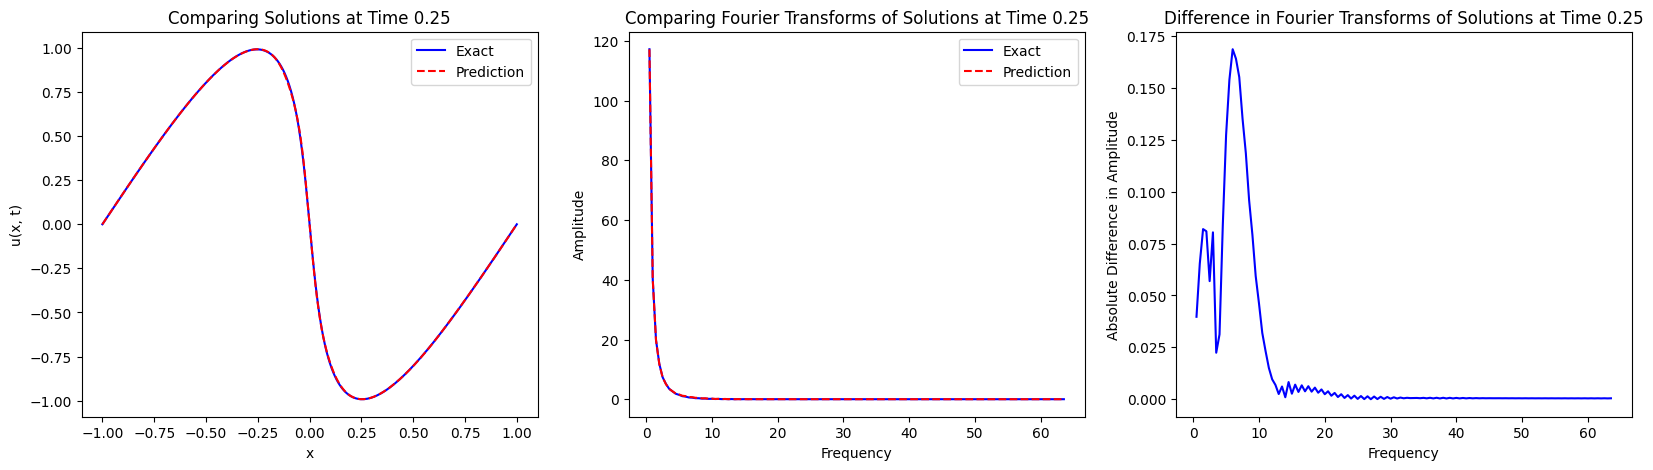

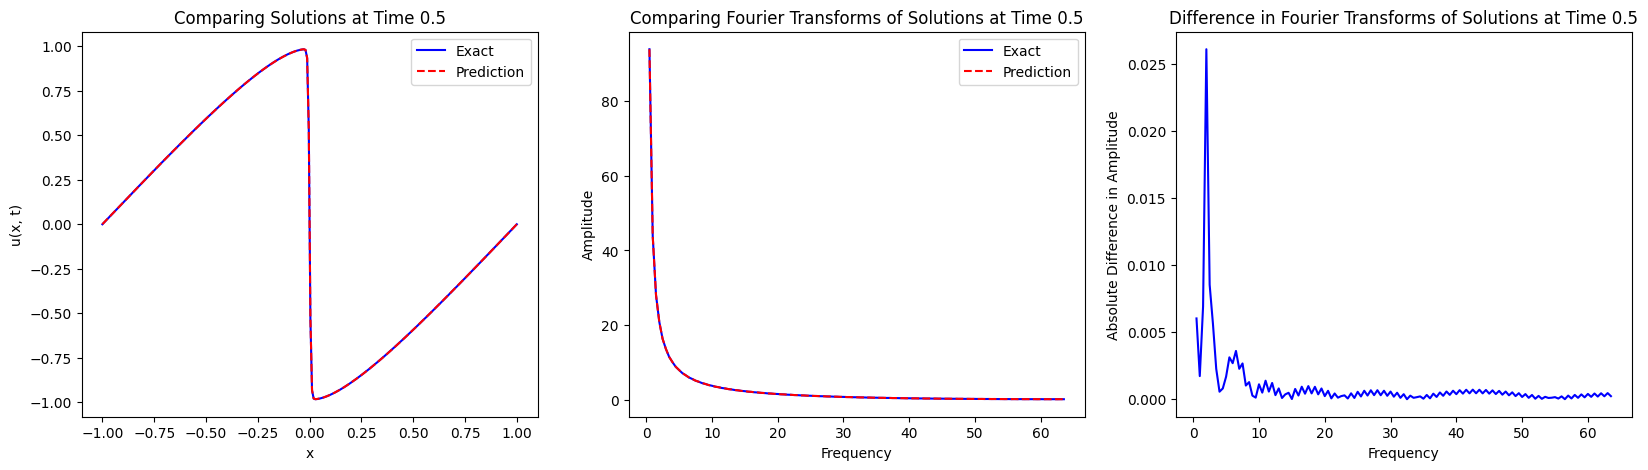

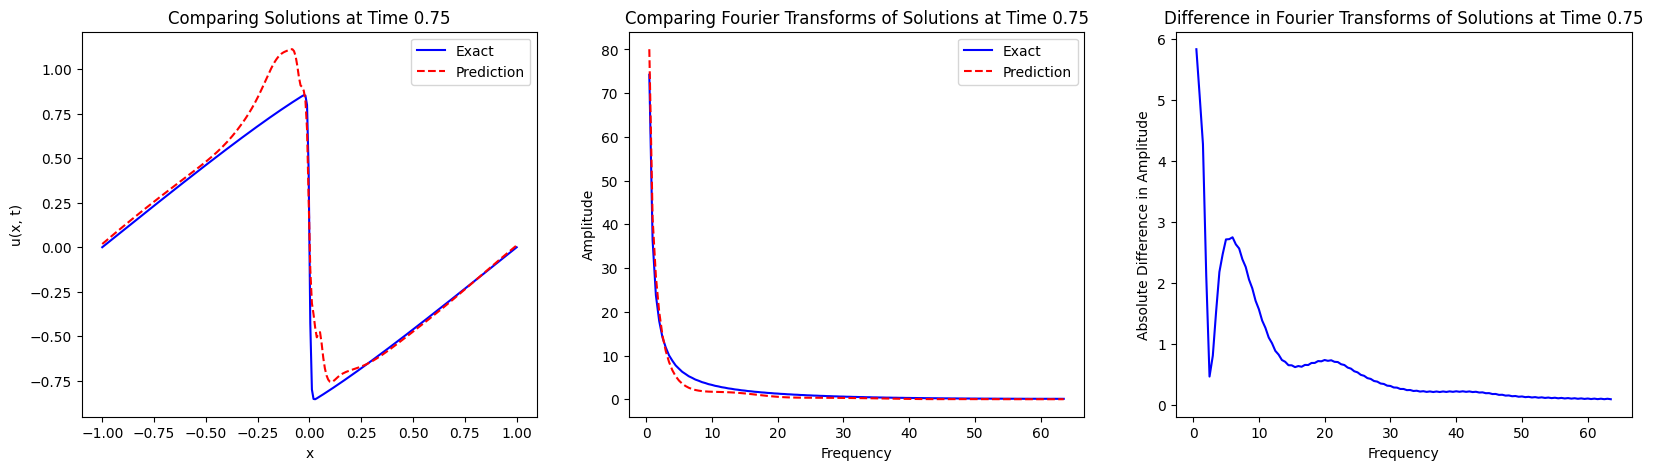

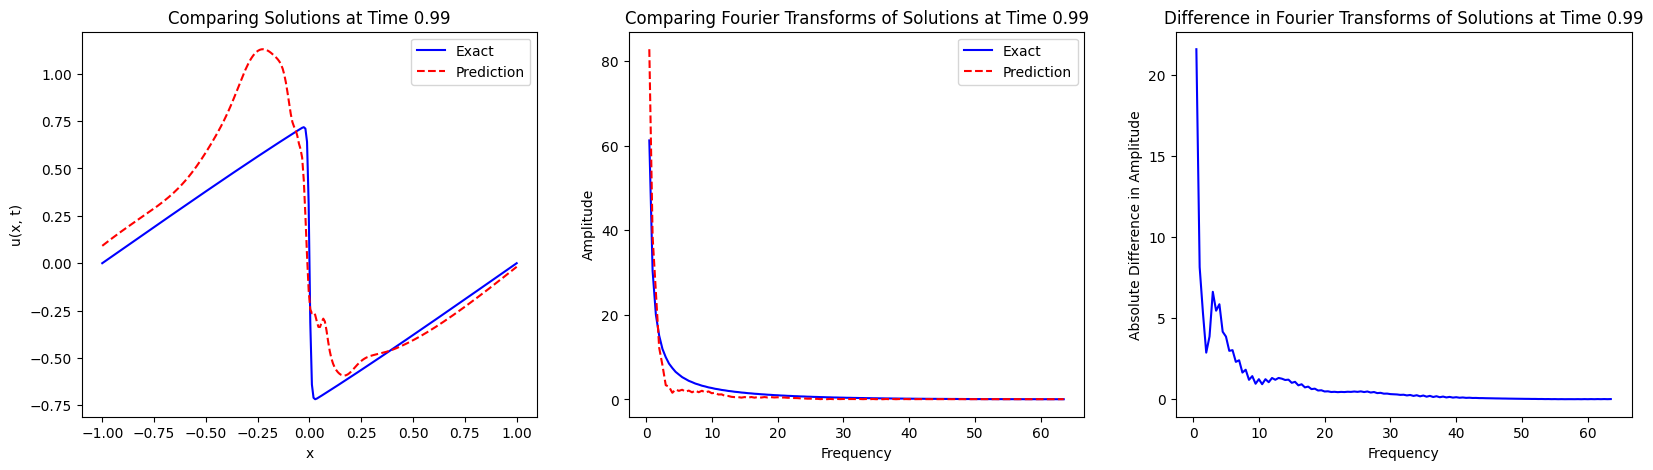

In [ ]:
compare_solutions(0, y_true, all_preds[300000])
compare_solutions(0.25, y_true, all_preds[300000])
compare_solutions(0.5, y_true, all_preds[300000])
compare_solutions(0.75, y_true, all_preds[300000])
compare_solutions(0.99, y_true, all_preds[300000])

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


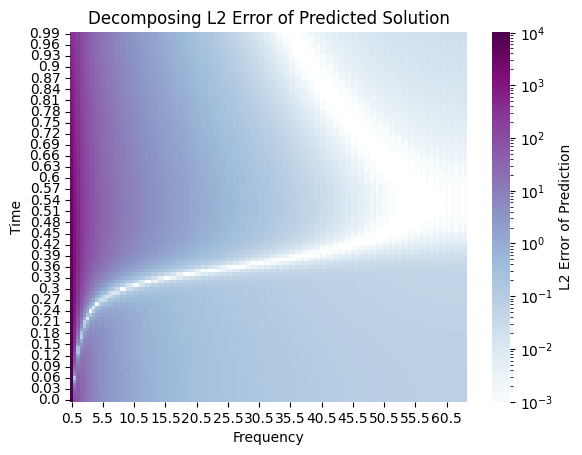

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


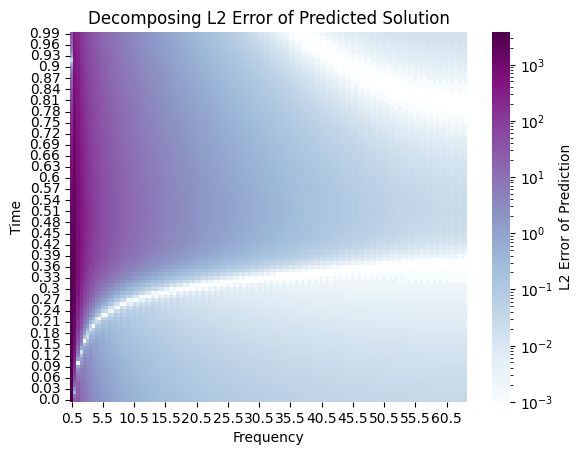

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


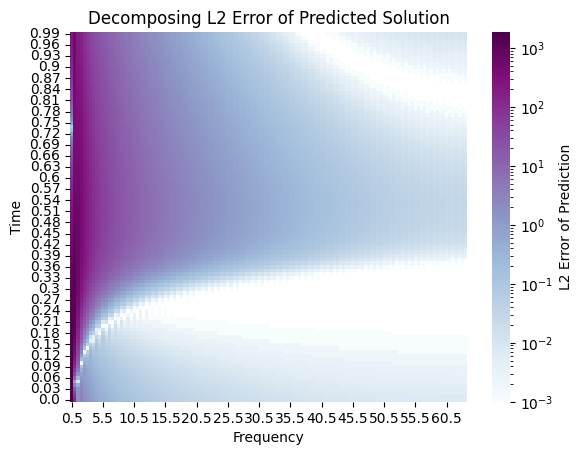

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


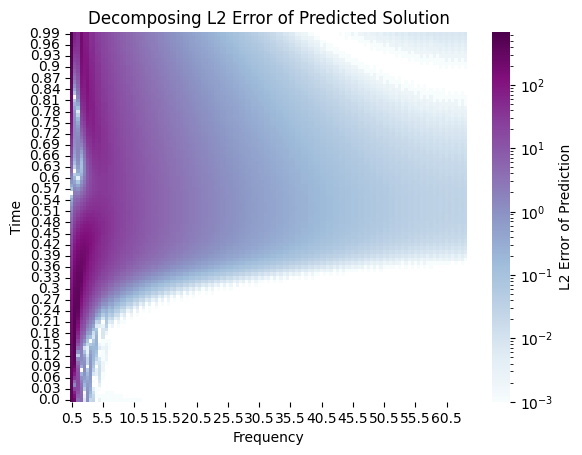

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


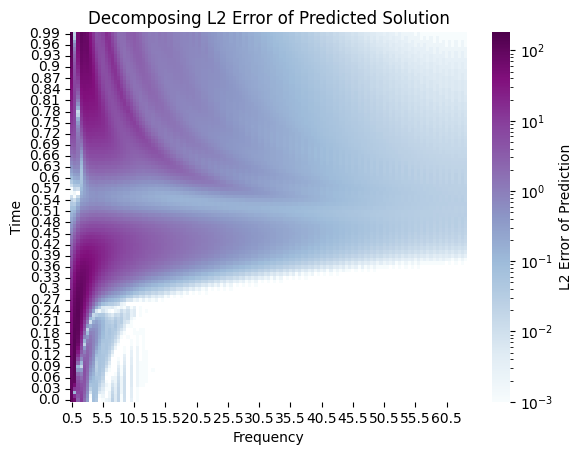

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


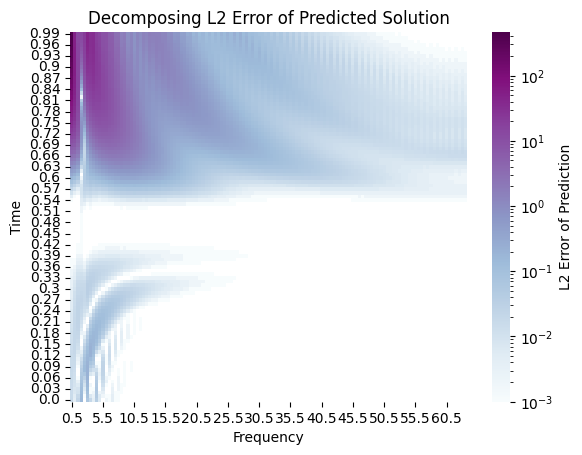

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


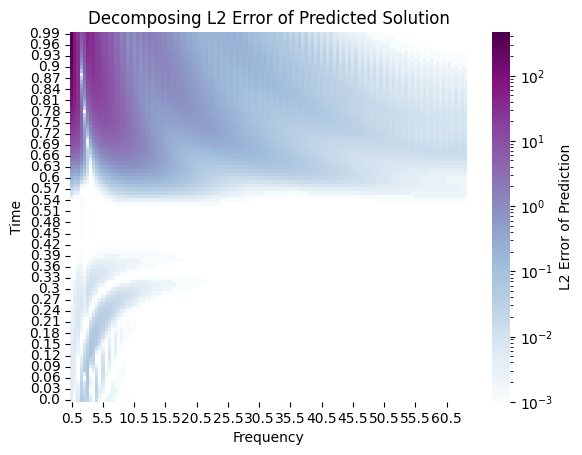

In [ ]:
plot_l2_errors(all_preds[1000], y_true, 1000)
plot_l2_errors(all_preds[5000], y_true, 5000)
plot_l2_errors(all_preds[10000], y_true, 10000)
plot_l2_errors(all_preds[20000], y_true, 20000)
plot_l2_errors(all_preds[50000], y_true, 50000)

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


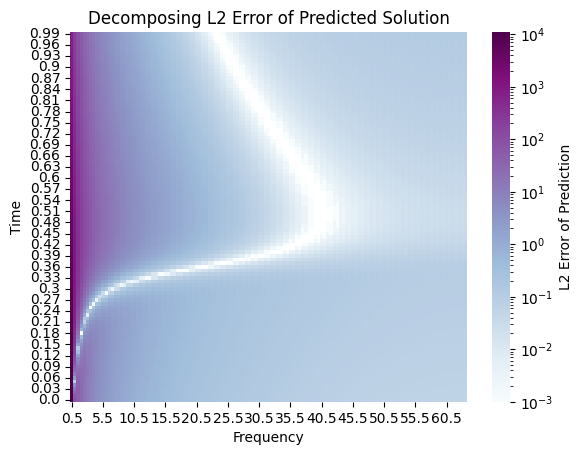

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


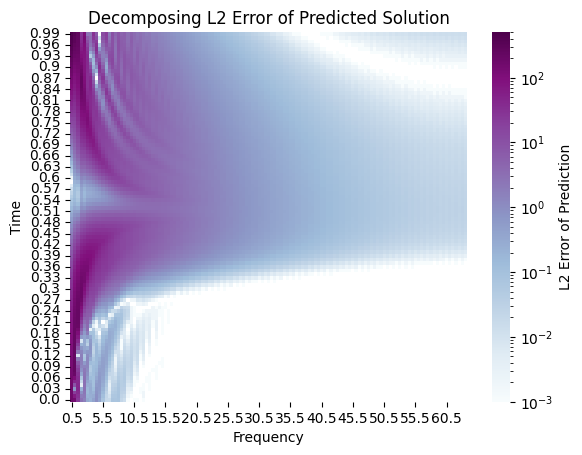

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


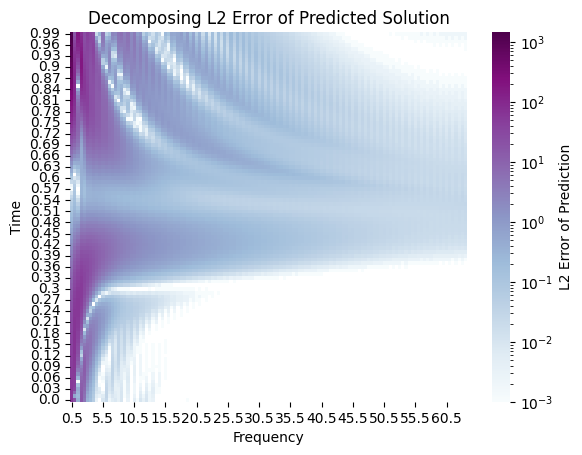

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


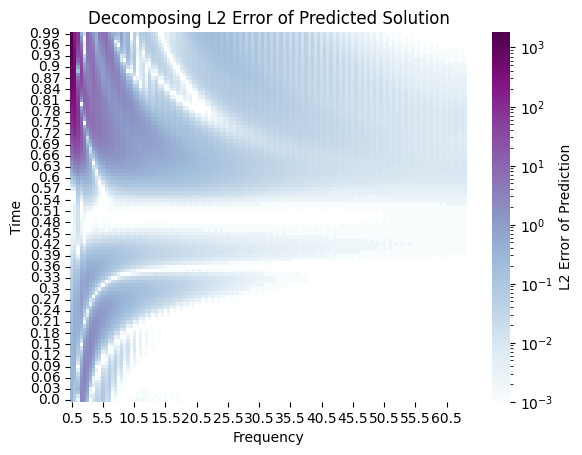

<ipython-input-68-84ab0d5e2fd5>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "freq", "value")


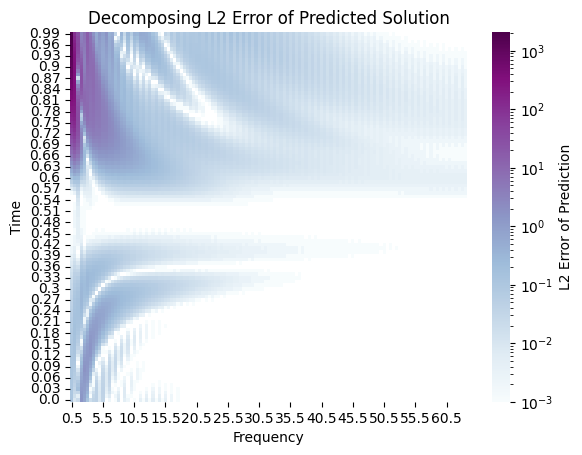

In [ ]:
plot_l2_errors(all_preds[500], y_true, 500)
plot_l2_errors(all_preds[50000], y_true, 50000)
plot_l2_errors(all_preds[100000], y_true, 100000)
plot_l2_errors(all_preds[200000], y_true, 200000)
plot_l2_errors(all_preds[300000], y_true, 300000)